# Simple Object Detection in Tensorflow

This lab will walk you through how to use object detection models available in [Tensorflow Hub](https://www.tensorflow.org/hub). In the following sections, you will:

* explore the Tensorflow Hub for object detection models
* load the models in your workspace
* preprocess an image for inference
* run inference on the models and inspect the output

Let's get started!

## Imports

In [1]:
%pip install tensorflow_hub
%pip install keras

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageOps
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

### Download the model from Tensorflow Hub

Tensorflow Hub is a repository of trained machine learning models which you can reuse in your own projects.
- You can see the domains covered [here](https://tfhub.dev/) and its subcategories.
- For this lab, you will want to look at the [image object detection subcategory](https://tfhub.dev/s?module-type=image-object-detection).
- You can select a model to see more information about it and copy the URL so you can download it to your workspace.
- We selected a [inception resnet version 2](https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1)
- You can also modify this following cell to choose the other model that we selected, [ssd mobilenet version 2](https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2)

In [3]:
# you can switch the commented lines here to pick the other model

# inception resnet version 2
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

# You can choose ssd mobilenet version 2 instead and compare the results
#module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"

#### Load the model

Next, you'll load the model specified by the `module_handle`.
- This will take a few minutes to load the model.

In [4]:
model = hub.load(module_handle)

#### Choose the default signature

Some models in the Tensorflow hub can be used for different tasks. So each model's documentation should show what *signature* to use when running the model.
- If you want to see if a model has more than one signature then you can do something like `print(hub.load(module_handle).signatures.keys())`. In your case, the models you will be using only have the `default` signature so you don't have to worry about other types.

In [5]:
# take a look at the available signatures for this particular model
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction () -> Dict[['detection_scores', TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)], ['detection_class_entities', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)], ['detection_boxes', TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)], ['detection_class_labels', TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)], ['detection_class_names', TensorSpec(shape=(None, 1), dtype=tf.string, name=None)]] at 0x7F7541217E20>}))

Please choose the 'default' signature for your object detector.
- For object detection models, its 'default' signature will accept a batch of image tensors and output a dictionary describing the objects detected, which is what you'll want here.

In [6]:
detector = model.signatures['default']

### download_and_resize_image

This function downloads an image specified by a given "url", pre-processes it, and then saves it to disk.

In [7]:
def download_and_resize_image(url, new_width=256, new_height=256):
    '''
    Fetches an image online, resizes it and saves it locally.

    Args:
        url (string) -- link to the image
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image

    Returns:
        (string) -- path to the saved image
    '''


    # create a temporary file ending with ".jpg"
    _, filename = tempfile.mkstemp(suffix=".jpg")

    # opens the given URL
    response = urlopen(url)

    # reads the image fetched from the URL
    image_data = response.read()

    # puts the image data in memory buffer
    image_data = BytesIO(image_data)

    # opens the image
    pil_image = Image.open(image_data)

    # resizes the image. will crop if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)

    # converts to the RGB colorspace
    pil_image_rgb = pil_image.convert("RGB")

    # saves the image to the temporary file created earlier
    pil_image_rgb.save(filename, format="JPEG", quality=90)

    print("Image downloaded to %s." % filename)

    return filename

### Download and preprocess an image

Now, using `download_and_resize_image` you can get a sample image online and save it locally.
- We've provided a URL for you, but feel free to choose another image to run through the object detector.
- You can use the original width and height of the image but feel free to modify it and see what results you get.

In [8]:
# You can choose a different URL that points to an image of your choice
image_url = "https://upload.wikimedia.org/wikipedia/commons/f/fb/20130807_dublin014.JPG"

# download the image and use the original height and width
downloaded_image_path = download_and_resize_image(image_url, 3872, 2592)

Image downloaded to /tmp/tmp3bazkiba.jpg.


<ipython-input-7-4e9bff65542d>:31: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)


### run_detector

This function will take in the object detection model `detector` and the path to a sample image, then use this model to detect objects and display its predicted class categories and detection boxes.
- run_detector uses `load_image` to convert the image into a tensor.

In [13]:
def load_img(path):
    '''
    Loads a JPEG image and converts it to a tensor.

    Args:
        path (string) -- path to a locally saved JPEG image

    Returns:
        (tensor) -- an image tensor
    '''

    # read the file
    img = tf.io.read_file(path)

    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)

    return img


def run_detector(detector, path):
    '''
    Runs inference on a local file using an object detection model.

    Args:
        detector (model) -- an object detection model loaded from TF Hub
        path (string) -- path to an image saved locally
    '''

    # load an image tensor from a local file path
    img = load_img(path)

    # add a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

    # run inference using the model
    result = detector(converted_img)

    # save the results in a dictionary
    result = {key:value.numpy() for key,value in result.items()}

    # print results
    print("Found %d objects." % len(result["detection_scores"]))

    print(result["detection_scores"])
    print(result["detection_class_entities"])
    print(result["detection_boxes"])
    return img, result


In [20]:
def display_image_with_boxes(image, boxes, scores, classes, class_names, threshold=0.5):
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for i in range(boxes.shape[0]):
        if scores[i] >= threshold:
            y_min, x_min, y_max, x_max = boxes[i]
            h = y_max - y_min
            w = x_max - x_min
            rect = patches.Rectangle(
                (x_min * image.shape[1], y_min * image.shape[0]),
                w * image.shape[1],
                h * image.shape[0],
                linewidth=2,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            plt.text(
                x_min * image.shape[1],
                y_min * image.shape[0] - 5,
                f'{class_names[i].decode("utf-8")}: {scores[i]:.2f}',
                color='red',
                fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.5)
            )
    plt.show()

### Run inference on the image

You can run your detector by calling the `run_detector` function. This will print the number of objects found followed by three lists:

* The detection scores of each object found (i.e. how confident the model is),
* The classes of each object found,
* The bounding boxes of each object

You will see how to overlay this information on the original image in the next sections and in this week's assignment!

Found 100 objects.
[0.6544854  0.61145365 0.604227   0.5926324  0.59218603 0.5804905
 0.55140555 0.49466994 0.47515708 0.47342214 0.4399594  0.41485175
 0.4062968  0.3982887  0.3976522  0.3762098  0.37279382 0.36574802
 0.3526071  0.33274597 0.30428725 0.2727656  0.26864928 0.2577708
 0.25290608 0.24612123 0.23403853 0.20342894 0.18229364 0.18045738
 0.1757127  0.16435127 0.15849987 0.15666083 0.15470858 0.15452757
 0.14924906 0.13340649 0.12948243 0.12649675 0.12044211 0.11767349
 0.11356074 0.11114738 0.11100248 0.10914914 0.10604038 0.08940525
 0.08598239 0.08280209 0.08104528 0.0780609  0.0776035  0.07628627
 0.07546879 0.07444175 0.07427193 0.07204817 0.07177558 0.07102216
 0.07032688 0.06809705 0.06304505 0.0628592  0.06270938 0.06223935
 0.05882129 0.0581505  0.05795779 0.05787582 0.05462391 0.05274323
 0.05133709 0.04826554 0.0470842  0.04682961 0.04495212 0.0440514
 0.04360704 0.04113467 0.04109954 0.03968571 0.03934991 0.03912783
 0.03879521 0.03878605 0.03739635 0.03606932 0

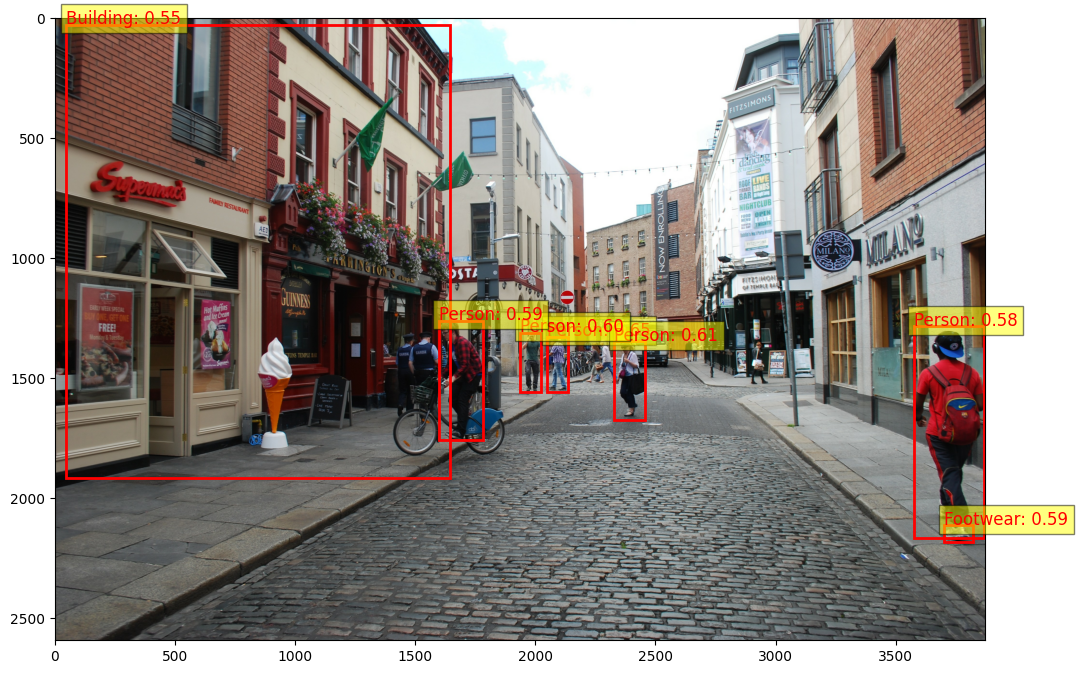

In [21]:
# runs the object detection model and prints information about the objects found
img, result = run_detector(detector, downloaded_image_path)
display_image_with_boxes(
    img.numpy(),
    result['detection_boxes'],
    result['detection_scores'],
    result['detection_class_entities'],
    result['detection_class_entities']
    )